# Implementing Dissipative Particle Dynamics in Molly

The aim of this workshop is to go through the process of implementing a numerical method from scratch using the software package [Molly](https://github.com/JuliaMolSim/Molly.jl), which is a Julia package for molecular simulation developed chiefly by Joe Greener of the [LMB](https://www2.mrc-lmb.cam.ac.uk/) in Cambridge.

For a video presentation of Molly's aims and capabilities, we refer you to Joe's [talk](https://youtu.be/trapn-yIv8g?t=1892) at JuliaCon 2022.

In this workshop, we will get familiar with some of Molly's many functionalities designed to make molecular simulation easy, as well as some of the tricks that go into implementing new ones efficiently.

To run this notebook, you will be needing a working installation of [Julia](https://julialang.org/) (we suggest the current stable release), as well as [IJulia](https://juliapackages.com/p/ijulia).

Before getting started, we set up and load the required dependencies.


The cell below installs dependencies, and is quite slow, so only run if you do not have Molly and GLMakie installed.

In [1]:
import Pkg

Pkg.add("Molly")
Pkg.add("GLMakie") # for visualization
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using Molly, GLMakie, Random, LinearAlgebra, Plots

The plan for the workshop is the following:
- Getting started with a Lennard-Jones fluid, neighbor lists and loggers
- Creating a custom interaction
- Creating a custom simulation loop

## Getting started: simulating the Lennard-Jones fluid

In this section we give a feel for how to simulate systems in Molly by working through simulating a Lennard-Jones fluid. We start by giving a minimal working example, and then simple tricks to make this example (much!) more efficient.

### Hello world

The main object in a simulation is a `System`. It holds all the parameters of the simulation: the types and physical characteristics of individual particles, the types and parameters of the various interactions, as well as a representation of the microscopic state and boundary condition, geometric constraints, and parameters defining the unit system.

We will be working with reduced units. We start by defining our microscopic state.
These are given two arrays, one for the coordinates and the other for the velocities.
The standard practice is, for performance reasons, to have both of these be of type `Vector{SVector{D,T}}` where `D` is the physical dimension and `T` is the element type.

We will initialize our coordinates on a cubic lattice grid, as defined in the following function.

In [3]:
function place_atoms_on_3D_lattice(Nx::Integer,Ny::Integer,Nz::Integer,boundary)
    (Lx,Ly,Lz)=boundary.side_lengths
    reshape([SVector(i * Lx/Nx, j* Ly/Ny, k * Lz/Nz) for i=0:Nx-1, j=0:Ny-1, k=0:Nz-1], Nx*Ny*Nz)
end

place_atoms_on_3D_lattice (generic function with 1 method)

Molly also provides functions to initialize the positions, such as
[`place_atoms`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.place_atoms-Tuple{Integer,%20Any}) and [`place_diatomics`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.place_diatomics-Tuple{Integer,%20Any,%20Any}) based on a rejection method.

Now we can define our physical parameters and initialize our coordinates and velocities.

In [4]:
T=0.8 #temperature
ρ = 0.4 #density

Nx = Ny = Nz = 10 # number of lattice sites for each dimension, 

N = Nx * Ny * Nz
α = cbrt( 1 / ρ ) # the fact that the lattice is cubic defines the geometry of the domain
Lx = α * Nx
Ly = α * Ny
Lz = α * Nz

boundary = CubicBoundary(Lx,Ly,Lz)
coords = place_atoms_on_3D_lattice(Nx,Ny,Nz,boundary)
atoms = [Atom(index = i,ϵ=1.0, σ=1.0, mass=1.0) for i=1:N]
velocities = [velocity(1.0,T,1.0) for i=1:N]


1000-element Vector{SVector{3, Float64}}:
 [-0.7098948183220236, -0.45697064257179104, -0.3761285206183965]
 [-1.016040725291929, -0.11521332172048854, -0.8916953008094011]
 [-1.7656700911538306, 2.6717428999336508, 0.48911804235375056]
 [0.6598352445257581, 0.6128521990756706, 1.1706597483326626]
 [-1.1601179852335715, -1.1392537949373827, -0.6928956008999873]
 [-1.6233768379775784, -0.5522209950411382, -0.25010529456002467]
 [0.9620898421071438, 1.891790066595733, -0.14873872531375038]
 [0.29022711262290496, -0.1990976297421796, 0.3943154372582704]
 [1.141763631442909, -2.0537291807427427, -1.284045663378375]
 [-0.5948274489050502, 1.7741521025497973, 0.6245093936609764]
 [-1.3986947583971951, -0.089070583160897, 0.5251999521119928]
 [0.30820654938507275, 0.34317338202567305, 0.9704074512124894]
 [-0.8003599791589777, 1.1592226002175823, 0.30187778149240596]
 ⋮
 [0.6936191479953001, -0.2753153150670051, 0.548002731484938]
 [1.3716938031270058, -1.3361701825084178, -1.9954711371464775

The `boundary` variable defines the boundary condition. For now Molly only accepts periodic boundary condition, with either a orthogonal unit cell, or a triclinic one, [`TriclinicBoundary`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.TriclinicBoundary).

The `coords` variable holds the initial coordinates.

The `atoms` contains a list of `Atom` objects (compatible with the [AtomsBase.jl](https://juliamolsim.github.io/AtomsBase.jl/stable/) interface), containing the physical characteristics of each particle, as well as optional additional info. $\epsilon$ and $\sigma$ are the Lennard-Jones parameters.

Now we can define our Lennard-Jones interaction:

In [5]:
lj_inter = LennardJones(force_units=NoUnits, energy_units= NoUnits)

LennardJones{false, NoCutoff, Int64, Int64, Unitful.FreeUnits{(), NoDims, nothing}, Unitful.FreeUnits{(), NoDims, nothing}}(NoCutoff(), false, true, 1, 1, , )

Molly defines many more [interactions](https://docs.juliahub.com/Molly/SNYdm/0.13.0/docs/#Forces), including specific interactions which apply to subsets of the particles, and can be used for instance to model chemical bonds.

Finally, we define our system:

In [6]:
sys = System(atoms=atoms,
    coords=coords,
    velocities=velocities,
    boundary=boundary,
    pairwise_inters=(lj_inter,),
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0)

System with 1000 atoms, boundary CubicBoundary{Float64}([13.572088082974531, 13.572088082974531, 13.572088082974531])

We can evolve the system according to a discretized Hamiltonian dynamics using the [`VelocityVerlet`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.VelocityVerlet) integrator, and simulate via the 
[`simulate!`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.simulate!-Tuple{Any,%20SteepestDescentMinimizer}) method:

In [7]:
dt=5e-3
simulator = VelocityVerlet(dt=dt)
@time simulate!(sys,simulator,2000)

  8.783354 seconds (6.65 M allocations: 2.921 GiB, 1.64% gc time, 20.16% compilation time)


System with 1000 atoms, boundary CubicBoundary{Float64}([13.572088082974531, 13.572088082974531, 13.572088082974531])

Let us check that the system is behaving reasonably by checking that the temperature is in check, plotting the histogram of velocities, and plot the particle positions.

temperature(sys) = 1.199621403635229


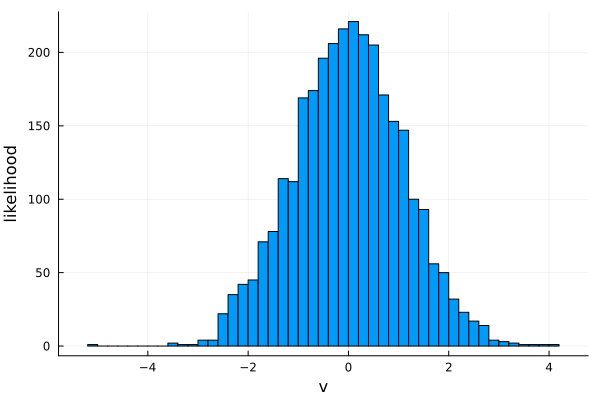

In [8]:
@show temperature(sys)
Plots.histogram(reinterpret(Float64,sys.velocities),bins=50,label="",xlabel="v",ylabel="likelihood")

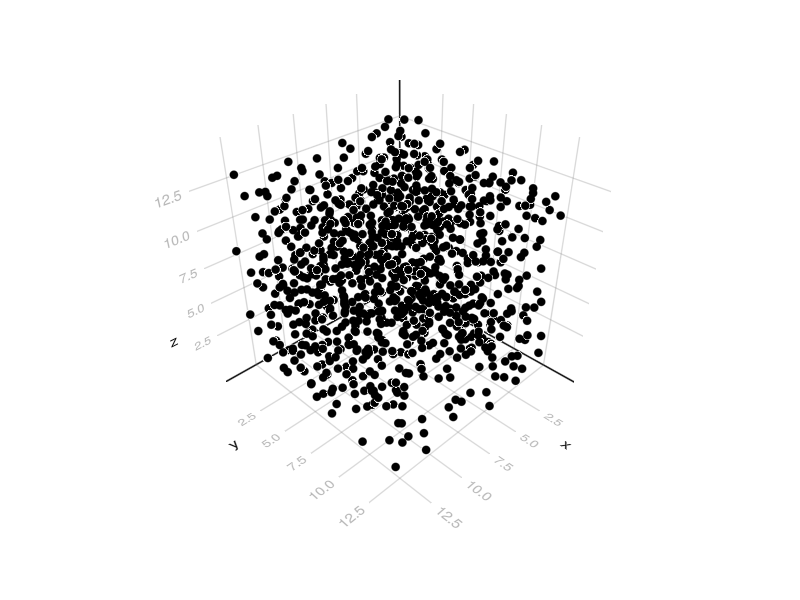

In [9]:
Makie.scatter(reinterpret(reshape,Float64,sys.coords))

Everything seems to work! The temperature is off from the initial condition, but this is expected since at this point there is no thermostatting. To do this, you can use the [`LangevinSplitting`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.LangevinSplitting) integrator, amongst other possibilities.

Things to play with:
- Changing the geometry of the domain by playing on the `Nx`,`Ny` and `Nz` parameters.
- Changing the density and initial velocity.
- Making the system inhomogeneous by changing the `mass` parameters in `atoms`.

### Neighbor lists

At this point we seem to have a working simulation, however the simulation at this point is extremely slow!
This is because at this point, Molly is integrating the dynamics deriving from the full Lennard-Jones pairwise potential. Because this is a short-ranged interaction, we can instead consider the approximation in which the contribution of distant pairs of particles is set to zero.

This is done by providing the interaction constructor with a cutoff parameter. Molly defines several types of [cutoff strategies](https://docs.juliahub.com/Molly/SNYdm/0.13.0/docs/#Cutoffs), but it is also possible, to write a custom cutoff.

Once a cutoff is defined, we can take advantage of the fact that the interaction has a finite-range by storing nearby pairs of particles in a dedicated data structure called a neighbor list. Efficient algorithms to keep track of neighbor pairs can be used to drastically reduce the number of force computations per iteration.

A `neighbor_finder` can be provided to the `System` constructor, which will define the neighbor finding strategy.
Available neighbor finders can be found (here)[https://docs.juliahub.com/Molly/SNYdm/0.13.0/docs/#Neighbor-finders].
In practice, we recommend using the `CellListMapNeighborFinder`, at least for large systems.

This gives:

In [10]:
r_c = 2.5 # our cutoff radius
cutoff = ShiftedForceCutoff(r_c) # a linear-correction cutoff giving a C¹ potential
lj_w_cutoff = LennardJones(cutoff = cutoff, nl_only = true, force_units = NoUnits, energy_units = NoUnits)
nf = CellListMapNeighborFinder(nb_matrix = trues(N,N), unit_cell = sys.boundary, n_steps = 1, dist_cutoff = r_c)

CellListMapNeighborFinder{3, Float64}
  Size of nb_matrix = (1000, 1000)
  n_steps = 1
  dist_cutoff = 2.5

The `nb_matrix` argument is a Boolean matrix telling the neighbor finder which pairs of atoms are to be considered as potential neighbors.
The `unit_cell` is the periodic unit cell argument, and `n_steps` is the frequency with which to compute the neighbor pairs.

Now we can redefine our system with this additional feature, and time the simulation.

In [11]:
sys = System(atoms=atoms,
    coords=sys.coords,
    velocities=sys.velocities,
    boundary=boundary,
    pairwise_inters=(lj_w_cutoff,),
    neighbor_finder=nf,
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0)

@time simulate!(sys,simulator,2000)

  3.761259 seconds (6.15 M allocations: 2.911 GiB, 5.05% gc time, 42.69% compilation time)


System with 1000 atoms, boundary CubicBoundary{Float64}([13.572088082974531, 13.572088082974531, 13.572088082974531])

Much better! Notice however that the allocations have not changed. 
This is because Molly aims at making its simulations differentiable through the use of the [Zygote](https://github.com/FluxML/Zygote.jl) automatic differentiation engine.

For intuitively clear reasons, coordinate updates and velocities cannot in this case be performed in place. It is true that this is a slight drag on performance. There are two options:
- Define your custom simulation such that these updates are performed in-place.
- Define an in-place version of Molly's default integrators. In fact this could be integrated in the Molly source code by providing a `inplace=false` keyword argument to the `simulate!` function. This is a point to discuss with Joe Greener.

### Loggers
This is all and good, but we are actually interested in tracking the evolution of the system. This is achieved through the use of [loggers](https://docs.juliahub.com/Molly/SNYdm/0.13.0/docs/#Loggers). These are probes which are given regular access to the state of the systems, and can be used to record or output observables of the system.

In [12]:
coord_logger = CoordinateLogger(Float64,1) 
ke_logger = KineticEnergyLogger(Float64,1)
pe_logger = PotentialEnergyLogger(Float64,1)

## the integer arguments correspond to the logging frequency of each observable.

loggers=(coords=coord_logger, ke=ke_logger,pe=pe_logger)

sys = System(atoms=atoms,
    coords=sys.coords,
    velocities=sys.velocities,
    boundary=boundary,
    pairwise_inters=(lj_w_cutoff,),
    neighbor_finder=nf,
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0,
    loggers=loggers)

simulate!(sys,simulator,2000)

System with 1000 atoms, boundary CubicBoundary{Float64}([13.572088082974531, 13.572088082974531, 13.572088082974531])

We can access the values stored in a given logger by calling `values(my_logger)`. In the next plot we check that the Hamiltonian is preserved.

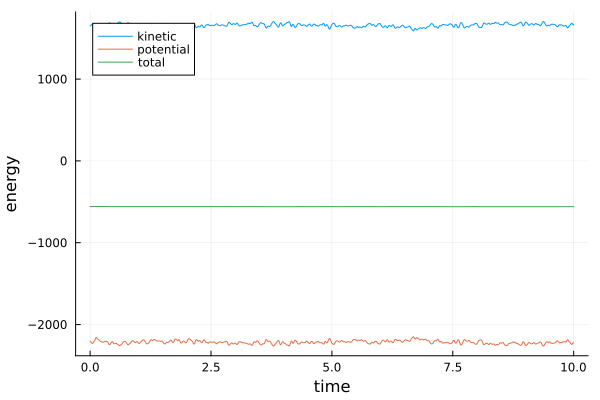

In [13]:
ts=(0:2000)*dt
values(sys.loggers.ke)
Plots.plot(ts,values(sys.loggers.ke),label="kinetic",xlabel="time",ylabel="energy")
Plots.plot!(ts,values(sys.loggers.pe),label="potential")
Plots.plot!(ts,values(sys.loggers.pe) + values(sys.loggers.ke),label="total")

We can visualize the evolution of the system by using Molly's [`visualize`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.visualize) function, which relies on `GLMakie`. A movie of the evolution is saved.


In [14]:
visualize(sys.loggers.coords,sys.boundary,"movie_test.mp4")

"movie_test.mp4"

<video controls src="movie_test.mp4" > </video>

Instead of recording the atom's trajectories in memory, you can output to a PDB file using Molly's [`StructureWriter`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.StructureWriter), and render the result using an external tool such as [VMD](https://www.ks.uiuc.edu/Research/vmd/) or [PyMol](https://pymol.org/2/).

It is also possible to write custom loggers, which is often useful to customize output behavior.
This is done by defining a custom `struct MyLogger` holding your logger's internal state and parameters, and a method `log_property!(logger::MyLogger, system, neighbors=nothing, step_n=0; n_threads=Threads.nthreads())`. 
This function will be called on every iteration of the simulation. Thus, it is given the number of the iteration step (the `step_n` argument) to allow for periodic logging. It is also given the currently calculated neighbors, as well as the number of available threads.

We can take advantage of this to track how often the neighbor list changes, and tune the frequency of neighbor calculations.

In [15]:
mutable struct NeighborDiffLogger{T}
    last_neighbors::T
    n_diffs::Vector{Int64}
end
NeighborDiffLogger(neighbors) = NeighborDiffLogger(neighbors,Int64[])

function Molly.log_property!(logger::NeighborDiffLogger, system, neighbors=nothing, step_n=0; n_threads=Threads.nthreads())
    n_diff = length(setdiff(Set(neighbors.list[1:neighbors.n]),Set(logger.last_neighbors.list[1:logger.last_neighbors.n])))
    push!(logger.n_diffs,n_diff)
    logger.last_neighbors = deepcopy(neighbors) # copy the neighbors.
end

Now we can test this:

In [16]:
initial_neighbors = find_neighbors(sys, sys.neighbor_finder) #
nl_diff_logger = NeighborDiffLogger(initial_neighbors) 

## the integer arguments correspond to the logging frequency of each observable.

loggers=(nl_diffs=nl_diff_logger,)

sys = System(atoms=atoms,
    coords=sys.coords,
    velocities=sys.velocities,
    boundary=boundary,
    pairwise_inters=(lj_w_cutoff,),
    neighbor_finder=nf,
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0,
    loggers=loggers)

simulator=VelocityVerlet(dt=1e-4) # take a small timestep to make my point
simulate!(sys,simulator,10000)

System with 1000 atoms, boundary CubicBoundary{Float64}([13.572088082974531, 13.572088082974531, 13.572088082974531])

In [36]:
diffs = sys.loggers.nl_diffs.n_diffs[4:end] #bug to understand here
println(sys.loggers.nl_diffs.last_neighbors.n)
Plots.histogram(diffs,xlabel="n_diffs",ylabel="number of times")

LoadError: type NamedTuple has no field nl_diffs


We see the number of updates to the neighbor list is of the order 10 while the length of the neighbor list is of the order 10000. Hence, at the cost of some small bias, it is generally acceptable to not recompute the neighbor list at every single step. The optimal strategy depends of course on the timestep and the temperature.

Things to play around with:
- Changing the timestep and temperature, and observing 
- Quantify the bias as a function of the neighbor computation frequency
- Try changing the simulators to a `LangevinSplitting`.

For loggers which simply record observables, Molly defines the `GeneralObservableLogger(observable::Function,T::DataType,n_steps::Int)` constructor, which returns a logger recording `observable` every `n_steps` iterations of the simulation, where `observable` has return type `T`. `observable` is assumed to implement the method `observable(sys::System , neighbors ; n_threads::Int)`.

## Creating a custom interaction

We now turn to the task of creating a custom simulator for a specific numerical method, splitting schemes for DPD. 
Dissipative particle dynamics is a stochastic differential equation designed to capture hydrodynamic effects on a mesoscopic scale. We base our implementation on the presentation given in [this preprint](https://arxiv.org/pdf/2005.05260.pdf) by Xiaocheng Shang.

For a system of $N$ particles with symmetric mass-matrix $M$, the equation of motion is given by

$$
\left\{\begin{aligned}
\mathrm{d} q_{t} &= M^{-1}p_{t}\,\mathrm{d}t,\\
\mathrm{d} p_{t} &= -\nabla V(q_t)\,\mathrm{d}t- \Gamma(q_t)M^{-1}p_t\,\mathrm{d}t + \Sigma(q_t)\,\mathrm{d}W_t.
\end{aligned}\right.
$$
The position-dependent friction and fluctuation coefficients $\Gamma$ and $\Sigma$ are matrices which are determined such that the evolution is given by a superposition of a Hamiltonian evolution governed by the potential $V$ and $N(N-1)/2$ Ornstein-Uhlenbeck processes on each of the relative velocities
$$ v_{ij} = \left(M^{-1}p_i -M^{-1}p_j\right)\cdot \frac{q_i-q_j}{|q_i-q_j|},$$
more precisely, denote $r_{ij}=|q_i-q_j|$, $e_{ij}=(q_i-q_j)/r_{ij}$ the unit vector pointing from particle $j$ to particle $i$. Then the equation of motion for the $i$-th momentum is given, by
$$
\mathrm{d}p_{i,t} = -\nabla_{q_i}V(q_t)\,\mathrm{d}t+\sum_{i\neq j}\left[-\gamma\omega(r_{ij,t})v_{ij,t}e_{ij,t}\,\mathrm{d}t + \sqrt{2\gamma \omega(r_{ij,t})\beta^{-1}}\,\mathrm{d}W_{ij,t}\right].
$$

The $W_{ij}$ are independent standard Wiener processes. It is easy to check then that $$\Sigma\Sigma^\intercal = 2\Gamma \beta^{-1},$$
so that the $\beta$-canonical measure is preserved. Hence DPD belongs to the general family of Langevin equations, although since total momentum is also conserved, the dynamics is not ergodic.

The form of the potential is usually taken to be of the form 
$$
V(q) = \sum_{i\neq j} a_{ij}r_c\left(1-\frac{r_{ij}}{r_c}\right)^2 1_{r_{ij}<r_c},
$$
so that the force is linear in $r_{ij}$, and short-range, where the range is governed by the cutoff radius $r_c$.
The force on particle $i$ from particle $j$ is given by
$$F_{ij}=a_{ij}\left(1-\frac{r_{ij}}{r_c}\right)e_{ij}=a_{ij}\left(\frac1{r_{ij}}-\frac1{r_c}\right)(q_i-q_j)$$
for $r_{ij}<r_c$.

The function $\omega$ should be positive, and is often also taken to be short range,
$$ \omega(r)= \left(1-\frac{r}{r_c}\right)1_{r<r_c},$$
which allows for efficient computations.

To define a custom pairwise interaction in Molly (or any interaction for that matter), we need to define a type, which holds the parameters of the interaction.
For DPD, this includes the cutoff radius, the coefficients $a_{ij}$, but maybe also units, and the behaviour of the interaction with respect to the neighbor list.

In [18]:
struct DPDInteraction{S,T,U,V,F,E} <: PairwiseInteraction
    nl_only :: Bool # whether the interaction uses the neighbor list
    cutoff_radius :: S
    coefficients :: T # the parameters of the interaction, a callable (i,j) -> coefficients(i,j)
    
    # useful quantities
    sq_cutoff_radius :: U
    inv_cutoff_radius :: V
    
    # units
    force_units :: F
    energy_units :: E 
end

function DPDInteraction(;nl_only, cutoff_radius,coefficients , force_units = NoUnits, energy_units = NoUnits)    
    # precompute useful quantities
    sq_cutoff_radius = cutoff_radius^2
    inv_cutoff_radius = inv(cutoff_radius)
    
    S,T,U,V,F,E = typeof.([cutoff_radius, coefficients, sq_cutoff_radius, inv_cutoff_radius, force_units, energy_units])
    return DPDInteraction{S,T,U,V,F,E}(nl_only,cutoff_radius,coefficients,sq_cutoff_radius,inv_cutoff_radius,force_units,energy_units)
end

DPDInteraction

The force computation is given by implementing a method for `Molly.force(inter::MyInteractionType,dr,qi,qj,atom_i,atom_j,boundary)`. Here `dr` is the vector pointing from `qi` to `qj`, `atom_i` and `atom_j` are the `Atom`s corresponding to the particle pair. The method should return the contribution to the force acting on particle `j` from particle `i`.

In [19]:
function Molly.force(inter::DPDInteraction{S,T}, dr, qi, qj, atom_i, atom_j, boundary) where {S,T}
    r2=sum(abs2,dr)
    (r2 > inter.sq_cutoff_radius) && return zero(dr) # set force to zero beyond the cutoff radius
    
    i = atom_i.index
    j = atom_j.index 
    a_ij = inter.coefficients(i,j)
    
    return @fastmath a_ij*(inv(sqrt(r2)) - inter.inv_cutoff_radius)*dr
    
end

In [20]:
dpd_coefficients(i,j)=1.0
dpd_inter=DPDInteraction(nl_only=true,cutoff_radius=r_c,coefficients = dpd_coefficients,force_units=NoUnits,energy_units=NoUnits)

sys = System(atoms=atoms,
    coords=sys.coords,
    velocities=sys.velocities,
    boundary=boundary,
    pairwise_inters=(dpd_inter,),
    neighbor_finder=nf,
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0,)

System with 1000 atoms, boundary CubicBoundary{Float64}([13.572088082974531, 13.572088082974531, 13.572088082974531])

We can check that our function works by calling `Molly.forces(sys,neighbors)`.

In [21]:
neighbors=find_neighbors(sys,sys.neighbor_finder)
fs=forces(sys,neighbors)

1000-element Vector{SVector{3, Float64}}:
 [-0.7055058081537819, -0.18184996248336144, 0.01722557952036541]
 [0.49878804420159106, 0.1136355250716399, -0.6375797217097493]
 [0.4109253254575022, 0.1257796317333018, 0.5798033475786627]
 [0.0740091433545664, -0.12299488264978982, 0.06239418460406512]
 [0.7982142101587202, -0.025331034494606372, 0.17937624951318748]
 [-1.2683024677275136, -0.28876260482241334, 0.7004795398286534]
 [0.1079858966487712, 0.8119551788485446, 1.45407854844577]
 [-0.3915481965935817, 1.6070370379923813, 0.5850759921246546]
 [0.36108792936933454, 0.14657630850423858, 0.6894786107276971]
 [-0.09085886146131886, 0.3962384961256547, 1.005705122467387]
 [-0.1821431132909838, 1.2438901790205663, -0.46741928442996755]
 [0.4615747781613979, 0.5663428848631472, 0.8985190009218385]
 [0.5788784373051719, 0.7619904641009987, 0.1437513588175562]
 ⋮
 [-0.9526087372499642, 0.4266917299409846, 1.0043683020072502]
 [0.10406474284702319, -0.0605996737629757, 0.63621965234735]
 [-

Now that the behaviour of the interaction is defined, we need to define the simulation loop.

## Defining a custom simulator

We want to implement general splittings for DPD. This corresponds to a standard symplectic splitting for the Hamiltonian part of the dynamics, and further splitting the remaining parts in individual Ornstein-Uhlenbeck evolutions for each relative velocity. At the level of the generator, this corresponds to a further splitting of the fluctuation-dissipation generator into a sum
$$ \mathcal{L}_{\mathrm{O}} = \sum_{i}\sum_{j\neq i}\mathcal{L}_{\mathrm{O},ij}.$$
We refer to the review section of the article for details. Talay-Tubaro expansions show that the ordering of the splitting of the fluctuation-dissipation part does not influence bias properties of splitting schemes.

Similar to the implementation of loggers and interactions, the implementation of a simulator consists in the definition of a data type `MySimulator`, and the definition of a method for `Molly.simulate!(sys,simulator::MySimulator,n_steps,args... ; kwargs...)`. Since the `simulate!` function is not used internally, some flexibility is allowed for the definition of this method, except if one attempts to interface with higher order simulators such as [`TemperatureREMD`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.TemperatureREMD).

At any rate, let us define our data type.

In [22]:
struct DPDSplitting{S,T,U,V,W}
    ω::S # assume ω is a function r -> ω(r)
    γ::T # friction coefficient
    β::U
    splitting::V # The ordering of the splitting
    dt::W
end

function DPDSplitting(;ω, friction, temperature, k=1.0, splitting ,dt)
    β = inv(k*temperature)
    return DPDSplitting{S,T,U,V}(ω,γ,β,splitting)
end

DPDSplitting

Next, we need to define the integration loop. We start by defining the A and B steps.

In [23]:
function DPD_A_step!(s, dt_eff, neighbors)
    s.coords += s.velocities * dt_eff
    s.coords = wrap_coords.(s.coords, (s.boundary,))
end

function DPD_B_step!(s, dt_eff, acceleration_vector, compute_forces::Bool, n_threads::Int, neighbors)
    if compute_forces
        acceleration_vector .= accelerations(s, neighbors, n_threads=n_threads)
    end
    s.velocities += dt_eff * Molly.remove_molar.(acceleration_vector) #this is an idiosyncrasy related to Unitful
end

DPD_B_step! (generic function with 1 method)

The A step simply updates the coordinates and applies the periodic boundary conditions.
The B step is a bit more involved. It takes as an argument a boolean `compute_forces`, which tells the function if the coordinates (and hence the forces) are known at the time of the call. This is done to avoid unnecessary recomputations of the forces. Note that the velocity and coordinate updates are not in-place, here, but this can be changed if performance is a concern.

In fact, these steps are verbatim the same as `Molly.A_step!` and `Molly.B_step!`, which are defined internally (not part of the API) for the purpose of the `LangevinSplitting` simulator.

Now we need to define the O step, which is the most involved, and which is specific to DPD.
Using standard arguments from Itô calculus, we can show that the following update rule

$$
    v_i^{n+1} = v_i^n + \Delta v_{ij}^n e_{ij}^n,
$$

where

$$
    \Delta v_{ij}^n = v_{ij}^n( e^{-\tau_{ij}^n \Delta t}-1) + \sqrt{\frac{(1-e^{-2\tau \Delta t})}{\beta m_{ij}}}G_{ij}^n,
$$

with $G_{ij}^n$ i.i.d standard gaussians, $\tau_{ij}^n = \gamma \omega(r_{ij}^n) m_{ij}^{-1}$, and $m_{ij}$ is the relative mass
$$
m_{ij}=\frac{m_im_j}{m_i+m_j},
$$
corresponds to the analytic solution to the Ornstein-Uhlenbeck process on the relative velocity over one timestep $\Delta t$. Translating this gives the following method.

In [24]:
function DPD_O_step!(s,dt_eff,rng,γ,β,ω,neighbors)
    for k=1:neighbors.n
        (i,j,_)=neighbors.list[k]
        
        mi=s.atoms[i].mass
        mj=s.atoms[j].mass
        
        mij=mi*mj/(mi+mj) #relative mass
        
        dr=vector(s.coords[j],s.coords[i],s.boundary) #displacement
        vij_vec=s.velocities[i]-s.velocities[j]
        
        rij=sqrt(sum(abs2,dr)) # |q_i-q_j|
        vij=dot(vij_vec,dr)/rij # relative velocity
        
        ωij=ω(rij) 
        τij=γ*ωij/mij
        αij=exp(-τij*dt_eff)
        Δvij= vij*(αij-1)+sqrt((1-αij^2)/(β*mij))*randn(rng)
        
        sys.velocities[i] +=Δvij*dr/rij
        sys.velocities[j] -=Δvij*dr/rij
        
    end
end

DPD_O_step! (generic function with 1 method)

With high probability, I made sign mistake in the code above, and/or in the definition of the force. However there is a chance that several wrongs make a right, so that debugging by trial and error may produce a correct result from an incorrect piece of code.
Notice, since we are always dividing by $r_{ij}$, we have an opportunity to use the [Fast inverse square root](https://en.wikipedia.org/wiki/Fast_inverse_square_root) from Quake.
Anyway, we now define the `simulate!` method.

In [25]:
function Molly.simulate!(sys,simulator::DPDSplitting,n_steps; n_threads=Threads.nthreads(), rng = Random.GLOBAL_RNG)
    
    sys.coords = wrap_coords.(sys.coords, (sys.boundary,))
    neighbors = find_neighbors(sys, sys.neighbor_finder; n_threads=n_threads) # initialize neighbor list 
    run_loggers!(sys, neighbors, 0; n_threads=n_threads) # record initial logs
    accels_t = accelerations(sys, neighbors; n_threads=n_threads) #initialize forces

    effective_dts = [sim.dt / count(c, sim.splitting) for c in sim.splitting] #compute effective timesteps
    
    forces_known = !occursin(r"^.*B[^B]*A[^B]*$", sim.splitting) #determine if the forces are known at the end of a simulation loop

    force_computation_steps = map(collect(sim.splitting)) do op #determine if the forces are known for each B step
        if op == 'O'
            return false
        elseif op == 'A'
            forces_known = false
            return false
        elseif op == 'B'
            if forces_known
                return false
            else
                forces_known = true
                return true
            end
        end
    end

    step_arg_pairs = map(enumerate(sim.splitting)) do (j, op) # collect steps and arguments for each of the steps
        if op == 'A'
            return (DPD_A_step!, (sys, effective_dts[j]))
        elseif op == 'B'
            return (DPD_B_step!, (sys, effective_dts[j], accels_t, force_computation_steps[j], n_threads))
        elseif op == 'O'
            return (DPD_O_step!, (sys, effective_dts[j], rng, sim.γ,sim.β,sim.ω))
        end
    end
    
     for step_n in 1:n_steps #This is the actual simulation loop
        
        for (step!, args) in step_arg_pairs #perform each step in the splitting
            step!(args..., neighbors)
        end

        run_loggers!(sys, neighbors, step_n) #run all the loggers
        
        if step_n != n_steps
            neighbors = find_neighbors(sys, sys.neighbor_finder, neighbors, step_n;
                                        n_threads=n_threads) # update neighbor list
        end
    end
    
    return sys
end

This method is almost the same as the one for `LangevinSplitting` (only the steps changed!).  In fact, a possible idea for future development would be to have a general `SplittingSimulator` type allowing for user-defined substeps, and have DPD and Langevin integrators be special cases. This approach would avoid a lot of boiler-plate code to implement new splitting methods, such as those for Norton dynamics. Now we just have to test it!

We will consider the case where $a_{ij} = 0.2(-1)^{1+i+j}$.

In [26]:
#geometry and state
T=0.3
ρ = 0.6

Nx = Ny = Nz = 10 

N = Nx * Ny * Nz
α = cbrt( 1 / ρ )
Lx = α * Nx
Ly = α * Ny
Lz = α * Nz

boundary = CubicBoundary(Lx,Ly,Lz)
coords = place_atoms_on_3D_lattice(Nx,Ny,Nz,boundary)
atoms = [Atom(index = i,ϵ=1.0, σ=1.0, mass= 1.0) for i=1:N]
velocities = [velocity(1.0,T,1.0) for i=1:N]

#interactions 
r_c = 2.0
dt=5e-3
dpd_force_coefficients(i,j) = 0.2(-1.0)^(1+i+j) #Julia implements this operation efficiently
dpd_inter=DPDInteraction(nl_only=true,cutoff_radius=r_c,coefficients=dpd_force_coefficients,energy_units=NoUnits,force_units=NoUnits)

#loggers
coord_logger=CoordinateLogger(Float64,4) #record one in 4 frames
loggers=(coords=coord_logger,)

#neighbor finder
nf=CellListMapNeighborFinder(nb_matrix=trues(N,N),unit_cell=boundary,dist_cutoff=r_c,n_steps=1)

# system
sys = System(atoms=atoms,
    coords=coords,
    velocities=velocities,
    boundary=boundary,
    pairwise_inters=(dpd_inter,),
    loggers=loggers,
    neighbor_finder=nf,
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0,)

#simulator
ω(r)= (r<r_c) ? (1-r/r_c) : 0.0
sim=DPDSplitting(ω,0.2,inv(T),"ABOBA",dt)

remove_CM_motion!(sys) #remove the motion of the center of mass
println(sum(sys.velocities))

[-8.104628079763643e-15, -1.5543122344752192e-15, -1.2878587085651816e-14]


In [27]:
simulate!(sys,sim,4000)
println(sum(sys.velocities)) #check conservation of momentum property

[1.699196339188802e-13, 2.596811654598241e-13, -2.0594637106796654e-13]


In [28]:
visualize(sys.loggers.coords,sys.boundary,"test_dpd.mp4",color=[(i%2 ==0) ? :red : :blue for i=1:N])

"test_dpd.mp4"

<video controls src="test_dpd.mp4"></video>

As a final experiment, we will compute the velocity autocorrelation function 
$$ C(t) = \mathbb{E}_\mu\left[M^{-1}p_t \cdot M^{-1}p_0\right].$$
This can be done easily thanks to Molly's [`TimeCorrelationLogger`](https://docs.juliahub.com/Molly/SNYdm/0.13.0/api/#Molly.TimeCorrelationLogger), and can be useful for instance for Green-Kubo computations.

In [29]:
vel_observable(s,neighbors;kwargs...) = copy(s.velocities) #velocity observable
vel_ac_logger=TimeCorrelationLogger(vel_observable,vel_observable,
    eltype(sys.velocities),eltype(sys.velocities),
    N,
    1000)

loggers=(vel_ac=vel_ac_logger,)

sys = System(atoms=atoms,
    coords=sys.coords,
    velocities=sys.velocities,
    boundary=boundary,
    pairwise_inters=(dpd_inter,),
    loggers=loggers,
    neighbor_finder=nf,
    force_units=NoUnits,
    energy_units=NoUnits,
    k=1.0,)

simulate!(sys,sim,20000)

System with 1000 atoms, boundary CubicBoundary{Float64}([11.856311014966876, 11.856311014966876, 11.856311014966876])

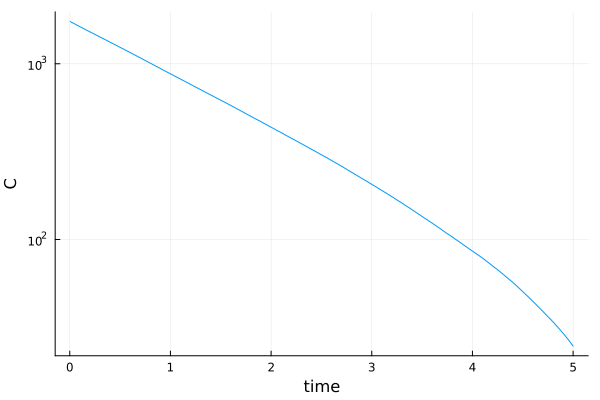

In [35]:
acs = values(sys.loggers.vel_ac,normalize=false)
ts=dt*(1:1000)
Plots.plot(ts,acs,xlabel="time",ylabel="C",label="",yaxis=:log)

This concludes our workshop.
To finish, a few things to play around with:
- Change the coefficients $a_{ij}$ and $\omega$
- Debug the code to check for sign errors

Also, a few more serious tasks:
- Profile the code using [ProfileCanvas.jl](https://github.com/pfitzseb/ProfileCanvas.jl), and optimize accordingly
- Figure out if multithreading is possible in the O step
- Design tests to validate the implementation
- Integrate the method into the Molly source code!

I hope this session provided a concise but still informative overview of some of Molly's basic features, as well as providing a kind of template for your own implementations.

I want to highlight that Molly is a young piece of software (pre-1.0 release) with a lot of room for optimization and also possibly non-backward compatible design changes. It is thus likely that future updates to Molly will break your current code.

It is also quite possible that you will find a bug or major performance issue. If this is the case, you should consider opening an issue, or submit your patch via a pull request on Molly's [GitHub](https://github.com/JuliaMolSim/Molly.jl) page. Finally, if you believe your implementations may be useful to the molecular simulation community, you should strive to make it available.

## Thank you!

